In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import scipy.io
import numpy as np
import pandas as pd

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,hidden_size3,output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        return x

In [3]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


## Lung Dataset

In [33]:
mat = scipy.io.loadmat("drive/MyDrive/datasets/lung.mat")

con_list = [[element for element in upperElement] for upperElement in mat['X']]

labels = mat['Y']
labels = np.array(labels.flatten())

df = pd.DataFrame(con_list)

In [34]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(df)
X = sc.transform(df)
type(X)

numpy.ndarray

In [35]:
lung_train_data, lung_test_data, lung_train_labels, lung_test_labels = train_test_split(
    X, np.array(labels), test_size=0.2, random_state=42
)

In [36]:
!pip install MiniSom

In [43]:
from minisom import MiniSom

# Train SOM for dimensionality reduction
som_shape = (10, 10)  # Grid size of the SOM
num_epochs_som = 1000
learning_rate = 0.5  # Initial learning rate
sigma = 1  # Initial neighborhood radius

som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=X.shape[1], sigma=sigma, learning_rate=learning_rate)

# Initialize the SOM
som = MiniSom(som_shape[0], som_shape[1], lung_train_data.shape[1])
som.train_random(lung_train_data, num_epochs_som)


In [44]:
# Map data to lower-dimensional space using the trained SOM
mapped_train_data = np.array([som.winner(x) for x in lung_train_data])
mapped_test_data = np.array([som.winner(x) for x in lung_test_data])

In [45]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(mapped_train_data)
X_test_tensor = torch.FloatTensor(mapped_test_data)

# One-hot encode the target labels
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = torch.FloatTensor(encoder.fit_transform(lung_train_labels.reshape(-1, 1)))
y_test_onehot = torch.FloatTensor(encoder.transform(lung_test_labels.reshape(-1, 1)))

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_onehot)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_onehot)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
# Set hyperparameters
input_size = 2
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 5

In [47]:
model = MLP(input_size, hidden_size1,hidden_size2,hidden_size3, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs =100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.argmax(dim=1).long())
      loss.backward()
      optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/100], Loss: 0.0171
Epoch [100/100], Loss: 0.0055


In [48]:
from sklearn.metrics import f1_score

model.eval()

all_predictions = []
all_true_labels = []

def get_cluster(arr):
  v=[]
  for a in arr:
    m, i = max((v, i) for i, v in enumerate(a))
    if m==0:
      v.append(0)
    else:
      v.append(i+1)
  return v

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_predictions.extend(get_cluster(outputs.numpy()))
        all_true_labels.extend(get_cluster(labels.numpy()))

# Convert lists to NumPy arrays
predicted_labels = np.array(all_predictions)
true_labels = np.array(all_true_labels)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels,  average='macro')
print(f'f1-score: {f1}')

f1-score: 0.9019607843137255


## Ids2 Dataset

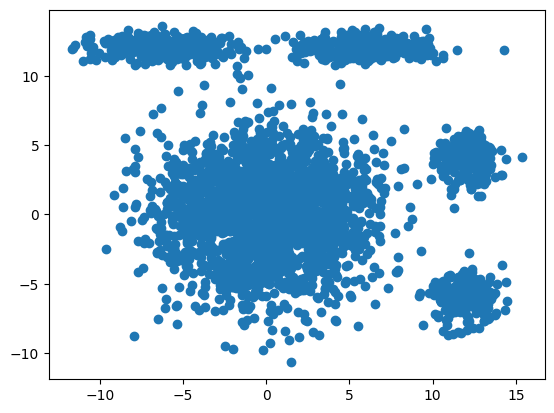

In [49]:
import matplotlib.pyplot as plt


mat = scipy.io.loadmat("/content/drive/My Drive/datasets/ids2.mat")

con_list = [[element for element in upperElement] for upperElement in mat['data']]

labels = mat['label']
labels = np.array(labels.flatten())

columns = ['data_x', 'data_y']
df = pd.DataFrame(con_list, columns=columns)
plt.scatter(x=df['data_x'], y=df['data_y'])

In [50]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(df)
X = sc.transform(df)
type(X)

numpy.ndarray

In [53]:
ids2_train_data, ids2_test_data, ids2_train_labels, ids2_test_labels = train_test_split(
    X, np.array(labels), test_size=0.2, random_state=42
)

In [54]:
from minisom import MiniSom

# Train SOM for dimensionality reduction
som_shape = (10, 10)  # Grid size of the SOM
num_epochs_som = 1000

# Initialize the SOM
ids2_som = MiniSom(som_shape[0], som_shape[1], ids2_train_data.shape[1], sigma=1.0, learning_rate=0.7)
ids2_som.train_random(ids2_train_data, num_epochs_som)


In [55]:
# Map data to lower-dimensional space using the trained SOM
mapped_train_data = np.array([ids2_som.winner(x) for x in ids2_train_data])
mapped_test_data = np.array([ids2_som.winner(x) for x in ids2_test_data])

In [56]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(mapped_train_data)
X_test_tensor = torch.FloatTensor(mapped_test_data)

# One-hot encode the target labels
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = encoder.fit_transform(ids2_train_labels.reshape(-1, 1))
y_test_onehot = encoder.transform(ids2_test_labels.reshape(-1, 1))

y_train_tensor = torch.FloatTensor(y_train_onehot)
y_test_tensor = torch.FloatTensor(y_test_onehot)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [57]:
# Set hyperparameters
input_size = 2
hidden_size1 = 256
hidden_size2 = 128
hidden_size2 = 64
output_size = 5

In [58]:
model = MLP(input_size, hidden_size1,hidden_size2,hidden_size3, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs =100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.argmax(dim=1).long())
      loss.backward()
      optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/100], Loss: 0.0056
Epoch [100/100], Loss: 0.0022


In [41]:
from sklearn.metrics import f1_score

model.eval()

all_predictions = []
all_true_labels = []

def get_cluster(arr):
  v=[]
  for a in arr:
    m, i = max((v, i) for i, v in enumerate(a))
    if m==0:
      v.append(0)
    else:
      v.append(i+1)
  return v

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_predictions.extend(get_cluster(outputs.numpy()))
        all_true_labels.extend(get_cluster(labels.numpy()))

# Convert lists to NumPy arrays
predicted_labels = np.array(all_predictions)
true_labels = np.array(all_true_labels)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels,  average='macro')
print(f'f1-score: {f1}')

f1-score: 0.993409482035414
